# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import shutil

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter

In [2]:
# Paths
clusters_dir = Path('../../../all_clusters/')
data_dir = Path('data/')
fragments_dir = Path('data/fragments/')
figures_dir = Path('figures/')

# Create figures directory if none exists
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)

# Load all data
tloops_raw = utils.load(data_dir/'tloops_raw.pickle')
tloops_filtered = utils.load(data_dir/'tloops_filtered.pickle')

chains_annotated_raw = utils.load(data_dir/'chains_annotated_raw.pickle')
chains_annotated_filtered = utils.load(data_dir/'chains_annotated_filtered.pickle')

fragments_8_raw = utils.load(fragments_dir/'fragments_8_raw.pickle')
fragments_8_filtered = utils.load(fragments_dir/'fragments_8_filtered.pickle')
fragments_10_filtered = utils.load(fragments_dir/'fragments_10_filtered.pickle')
fragments_12_filtered = utils.load(fragments_dir/'fragments_12_filtered.pickle')
fragments_14_filtered = utils.load(fragments_dir/'fragments_14_filtered.pickle')

In [3]:
# Other functions

def get_res_array(sequences:list[str], res_names:list[str]=['A','U','C','G']):
    res_array= np.zeros(shape=(len(res_names), len(sequences[0])))
    for seq in sequences:
        for pos, res in enumerate(seq):
            res_array[res_names.index(res)][pos] += 1
    res_array = res_array/res_array.sum(axis=0, keepdims=True)
    return res_array


def merge_pdfs_in_dir(dir:Path, filename:str='merged_pdf'):
    merger = PdfWriter()
    for item in dir.iterdir():
        merger.append(item)
    merger.write(dir.parent/(filename + '.pdf'))
    merger.close()
    shutil.rmtree(dir)


def format_filename(text:str):
    return text.lower().replace(' ','_')

In [4]:
# Plot functions

# Plot bar graph
def plot_bar(data:dict, title:str='', dir:Path=figures_dir) -> None:
    ax = plt.subplots(figsize=(len(data)*0.3,3))[1]
    bar_plot = ax.bar(range(len(data)), data.values(), align='edge', width=0.5)
    ax.bar_label(bar_plot, rotation='vertical', padding=5)
    ax.set_xticks(range(len(data)), data.keys(), rotation='vertical', horizontalalignment='left')
    ax.set_title(title, y=1.1)
    
    # Cosmetic adjustments
    ax.margins(x=0.5/len(data), tight=True)
    ax.spines[['right', 'top']].set_visible(False)
    
    save_pdf(dir/format_filename(title))


# Plot stacked bar graph
def plot_stacked_bar(x, array, labels:list[str], title:str='', dir:Path=figures_dir) -> None:
    ax = plt.subplots(figsize=(len(x)*0.3,3))[1]
    ax.bar(x, array[0], label=labels[0])
    for i in range(1, len(array)):
        ax.bar(x, array[i], bottom=np.sum(array[:i], axis=0), label=labels[i])
    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5,1.03))
    
    save_pdf(dir/format_filename(title))


def save_pdf(path:Path):
    plt.savefig(Path(path.with_suffix('.pdf')), bbox_inches='tight')
    plt.close()

In [5]:
def stats(data, label:str ='', seqs_hist:bool=False, clust_seqs_hist:bool=False, clust_hist:bool=False, res_pos_hist:bool=False) -> None:
    
    seqs = [i.res_seq for i in data] # Sequences
    pdb_ids = [i.pdb_id for i in data] # PDB IDs

    print(
        f'{label}:\n'
        f'- Amount: {len(data)}\n'
        f'- Unique sequences: {len(set(seqs))}\n'
        f'- PDB IDs: {len(set(pdb_ids))}'
    )
    if isinstance(data[0], Fragment) or isinstance(data[0], Chain):
        seq_ids = [i.seq_id for i in data] # Sequence IDs (PDB ID + chain ID)
        print(f'- Chains: {len(set(seq_ids))}')
    
    # Residue position histogram
    if res_pos_hist:
        res_array = get_res_array(seqs, ['A','U','C','G','N','I'])
        plot_stacked_bar(range(len(seqs[0])), res_array, ['A','U','C','G','N','I'], f'{label} residue position frequencies')
    
    # Sequence histogram
    if seqs_hist:
        seqs_dict = OrderedDict(Counter(seqs).most_common())
        plot_bar(seqs_dict, f'{label} sequence frequencies')
    
    # Sequence by cluster
    if clust_seqs_hist:
        tmp_dir = figures_dir/'tmp'#Path(f'{figures_dir}/tmp')
        if tmp_dir.exists() and tmp_dir.is_dir():
            shutil.rmtree(tmp_dir)
        tmp_dir.mkdir(parents=True, exist_ok=True)
    
        clust_ids = set([i.clust_id for i in data])
        for c in clust_ids:
            clust_seqs = [t.res_seq for t in data if t.clust_id == c]
            clust_seqs_dict = OrderedDict(Counter(clust_seqs).most_common())
            plot_bar(clust_seqs_dict, f'{label} cluster {c} sequence frequencies', dir=tmp_dir)
        merge_pdfs_in_dir(tmp_dir, format_filename(f'{label} cluster sequence frequencies.pdf'))
    
    # Cluster histogram
    if clust_hist:
        clust_ids = [t.clust_id for t in data]
        clust_ids_dict = OrderedDict(sorted(Counter(clust_ids).items()))
        plot_bar(clust_ids_dict, f'{label} cluster frequencies')

    print(f'Figures saved to /{figures_dir}\n')

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [6]:
# Cluster groups, as named in Bottaro et al. Table SI1
gnra = [1]
gnra_like = [1, 3, 6, 9, 25, 26, 36, 40]
uncg = [2]
uncg_like = [2, 5, 37, 44]
u_turn = [4]

In [7]:
stats(tloops_raw, 'Raw tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
stats(tloops_filtered, 'Filtered tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
tloop_fragments = [i for i in fragments_8_raw if i.clust_id != 0]
stats(tloop_fragments, 'Generated tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)

Raw tetraloops:
- Amount: 19383
- Unique sequences: 292
- PDB IDs: 864
Figures saved to /figures

Filtered tetraloops:
- Amount: 11952
- Unique sequences: 292
- PDB IDs: 864
Figures saved to /figures

Generated tetraloops:
- Amount: 5032
- Unique sequences: 289
- PDB IDs: 471
- Chains: 572
Figures saved to /figures



In [8]:
#! WHY ARE THESE 3 SEQUENCES MISSING??
tloops_raw = set([i.res_seq for i in tloops_raw])
tloop_fragments = set([i.res_seq for i in fragments_8_raw if i.clust_id != 0])

print(tloops_raw - tloop_fragments)

{'AGGCGACU', 'GCGUAAGC', 'AGGUGACU'}


# Chains

In [9]:
stats(chains_annotated_raw, 'Raw annotated chains')
stats(chains_annotated_filtered, 'Filtered annotated chains')

Raw annotated chains:
- Amount: 3284
- Unique sequences: 1032
- PDB IDs: 864
- Chains: 3284
Figures saved to /figures

Filtered annotated chains:
- Amount: 836
- Unique sequences: 709
- PDB IDs: 536
- Chains: 836
Figures saved to /figures



(array([264.,   0.,   0., 250.,   0.,   0.,   0.,  30.,   0.,   0.,   0.,
         10.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   3.,   0.,   0.,   3.,   0.,   0.,   0.,   4.,   0.,   0.,
          0.,   7.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   9.,   0.,
          0.,   0.,  14.,   0.,   0.,   0.,  18.,   0.,   0.,  16.,   0.,
          0.,   0.,  15.,   0.,   0.,   0.,  30.,   0.,   0.,   0.,  23.,
          0.,   0.,   0.,  24.,   0.,   0.,   0.,  20.,   0.,   0.,  20.,
          0.,   0.,   0.,  11.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,  12.,   0.,   0.,   0.,   4.,   0.,   0.,
          1.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14

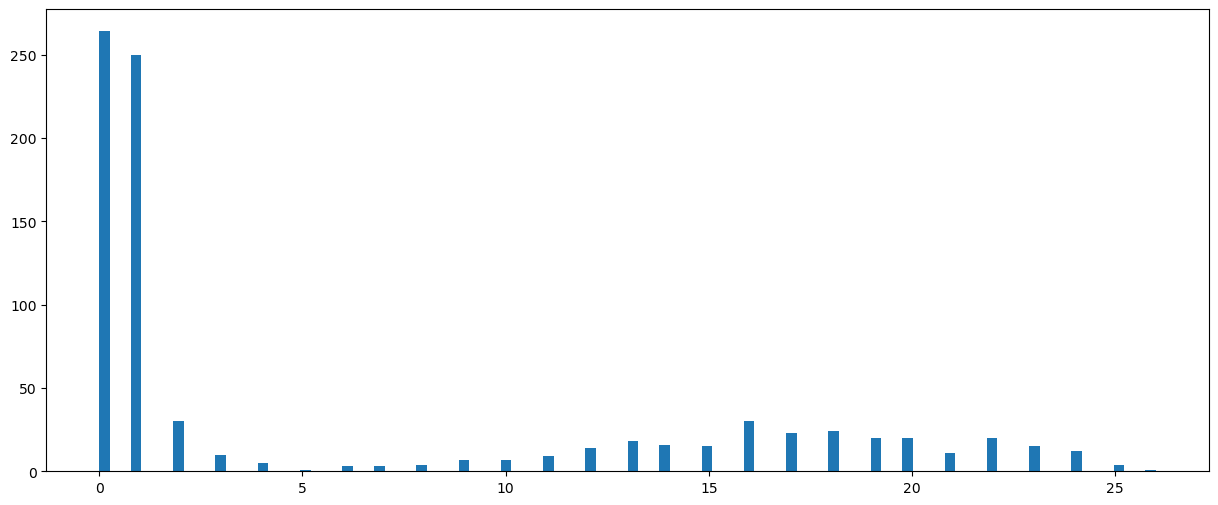

In [20]:
plt.figure(figsize=(15, 6))
# plt.hist([len(i.tloops) for i in chains_annotated_raw], bins=100)
plt.hist([len(i.tloops) for i in chains_annotated_filtered], bins=100)

# Fragments

## Unique fragments
The number of unique RNA fragments is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique fragments is $764646$.

In [ ]:
pos_unique_frags = 4**8
print(f'Possible unique fragments: {pos_unique_frags}')

print(f'Total # of fragments: {len(fragments_8_raw)}')
unique_fragments = len(set([i.res_seq for i in fragments_8_filtered]))
print(f'Unique fragments: {unique_fragments}')

expected_tries = sum([pos_unique_frags/(pos_unique_frags-i) for i in range(unique_fragments)])
print(f'Expected # tries to obtain {unique_fragments} unique fragments: {round(expected_tries)}')

Possible unique fragments: 65536
Total # of fragments: 661843
Unique fragments: 36375
Expected # tries to obtain 36375 unique fragments: 53068


## Fragment of different lengths

In [ ]:
tloops_8 = [i for i  in fragments_8_filtered if i.clust_id in gnra]
stats(tloops_8, 'Tetraloops 8', res_pos_hist=True)
tloops_10 = [i for i  in fragments_10_filtered if i.clust_id in gnra]
stats(tloops_10, 'Tetraloops 10', res_pos_hist=True)
tloops_12 = [i for i  in fragments_12_filtered if i.clust_id in gnra]
stats(tloops_12, 'Tetraloops 12', res_pos_hist=True)
tloops_14 = [i for i  in fragments_14_filtered if i.clust_id in gnra]
stats(tloops_14, 'Tetraloops 14', res_pos_hist=True)

Tetraloops 8:
- Amount: 2859
- Unique sequences: 150
- PDB IDs: 358
- Chains: 444


Figures saved to /figures

Tetraloops 10:
- Amount: 2859
- Unique sequences: 241
- PDB IDs: 358
- Chains: 444
Figures saved to /figures

Tetraloops 12:
- Amount: 2855
- Unique sequences: 298
- PDB IDs: 356
- Chains: 440
Figures saved to /figures

Tetraloops 14:
- Amount: 2849
- Unique sequences: 310
- PDB IDs: 350
- Chains: 434
Figures saved to /figures



In [31]:
print(len(set([i.res_seq for i in tloops_filtered if i.clust_id == 1])))

print(len(set([i.res_seq for i in fragments_14_filtered if i.clust_id == 1])))

[i.res_seq for i in tloops_filtered if i.clust_id == 1]

153
310


['GCGAAGGC',
 'CGGCAACG',
 'CGGAAACG',
 'UGGAAACA',
 'UCGUGAGA',
 'CCGUGAGG',
 'GGAAGCUC',
 'UCGUGAGA',
 'CCGCGAGG',
 'CAGCGAUG',
 'GCGAAGGC',
 'CCGCGAGG',
 'GCGCGAGC',
 'CCUCACGG',
 'CUGAGAGG',
 'UCGUGAGA',
 'CCGAAAGG',
 'CCGUGAGG',
 'AGGUGACU',
 'GGGAAACC',
 'UCGUGAGA',
 'CAGCGAUG',
 'CCGCAAGG',
 'CCGCAAGG',
 'AUGAAAGU',
 'ACGAAAGU',
 'GUGAAAGC',
 'ACGCGAGU',
 'CCGUGAGG',
 'CUGAGAGG',
 'GCGAAGGC',
 'UCGCAAGA',
 'GUGAAAGC',
 'GUGUGAAC',
 'CCGGGAGG',
 'GCGAAAGC',
 'GGGCGACC',
 'GUGAAAGC',
 'UCGUGAGA',
 'CAGAGAUG',
 'UCGUGAGA',
 'UCGUAAGA',
 'UGGAAACG',
 'UCGCAAGA',
 'CCGGGAGG',
 'CCGCGAGG',
 'GGGAAACC',
 'UAGCAAUG',
 'GGGAAACC',
 'CCGUGAGG',
 'CCGGAAGG',
 'UAGCAAUG',
 'CCGGAAGG',
 'GGGGAACC',
 'GCGAAAGC',
 'CCGUGAGG',
 'CCGAAAGG',
 'CCGCAAGG',
 'CCGCGAGG',
 'UCGCAAGA',
 'CCGGAAGG',
 'GCGAGAGC',
 'GGGAAACU',
 'CCGUGAGG',
 'CCUCACGG',
 'CCGAAAGG',
 'CUGACACG',
 'CCGUGAGG',
 'GCGAAGGC',
 'GCGAAAGC',
 'CUGAGAGG',
 'CCGGAAGG',
 'GCUAACGC',
 'UCGUGAGA',
 'GCGCAAGC',
 'GUGAAAAC',
 'GUGCAAGC',